https://github.com/nerfstudio-project/gsplat/issues/234

In [62]:
import os
import torch
import numpy as np
import struct
from gsplat import rasterization
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# path of ply file
file_path = os.path.abspath(os.path.join("..", "data", "point_cloud.ply"))

In [64]:
with open(file_path, 'rb') as f:
    header_lines = []
    for line in f:
        decoded_line = line.decode('utf-8', errors='ignore').strip()
        header_lines.append(decoded_line)
        if decoded_line == "end_header":
            break

print("PLY Header:")
print("\n".join(header_lines))

PLY Header:
ply
format binary_little_endian 1.0
element vertex 899421
property float x
property float y
property float z
property float nx
property float ny
property float nz
property float f_dc_0
property float f_dc_1
property float f_dc_2
property float f_rest_0
property float f_rest_1
property float f_rest_2
property float f_rest_3
property float f_rest_4
property float f_rest_5
property float f_rest_6
property float f_rest_7
property float f_rest_8
property float f_rest_9
property float f_rest_10
property float f_rest_11
property float f_rest_12
property float f_rest_13
property float f_rest_14
property float f_rest_15
property float f_rest_16
property float f_rest_17
property float f_rest_18
property float f_rest_19
property float f_rest_20
property float f_rest_21
property float f_rest_22
property float f_rest_23
property float f_rest_24
property float f_rest_25
property float f_rest_26
property float f_rest_27
property float f_rest_28
property float f_rest_29
property float f_re

In [65]:
# # read ply file
# def load_ply(file_path):
#     """
#     Load a 3dgs PLY file and return a dictionary of torch.Tensors
#     containing Gaussian parameters.

#     The expected property order is as follows:
#       1. x, y, z          -> means, shape [N, 3]
#       2. nx, ny, nz       -> normals (unused, written as zeros)
#       3. Color block: Either:
#          - Plain colors: properties "f_dc_0", "f_dc_1", ..., representing
#            transformed colors, or
#          - SH coefficients: two blocks; first block ("f_dc_0", …) and
#            second block ("f_rest_0", …). In this case, if each block has M floats,
#            we require M to be divisible by 3. Then the SH coefficients are recovered
#            by reshaping each block to [N, K, 3] with K = M / 3.
#       4. opacity          -> opacities, shape [N]
#       5. scale_*          -> scales, shape [N, 3]
#       6. rot_*            -> quaternions, shape [N, 4]

#     Returns a dictionary with keys:
#       - "means", "quats", "scales", "opacities"
#       - If plain colors are used: "colors" of shape [N, D]
#       - If SH coefficients are used: "sh0" and "shN", each of shape [N, K, 3]
#     """
#     with open(file_path, "rb") as f:
#         # Read header lines until "end_header"
#         header_lines = []
#         while True:
#             line = f.readline().decode("utf-8").strip()
#             header_lines.append(line)
#             if line == "end_header":
#                 break

#         # Parse header to determine number of vertices and property order.
#         num_vertices = 0
#         properties = []
#         for line in header_lines:
#             if line.startswith("element vertex"):
#                 num_vertices = int(line.split()[2])
#             elif line.startswith("property"):
#                 tokens = line.split()
#                 if len(tokens) >= 3:
#                     properties.append(tokens[2])

#         # The first 3 properties are the means (x,y,z)
#         idx = 0
#         means_idx = list(range(idx, idx + 3))
#         idx += 3

#         # Next 3 are normals (unused)
#         normals_idx = list(range(idx, idx + 3))
#         idx += 3

#         # Next block: either color values or SH coefficients until we hit "opacity".
#         try:
#             opacity_index = properties.index("opacity")
#         except ValueError:
#             raise ValueError("Header does not contain an 'opacity' property.")
        
#         color_props = properties[idx:opacity_index]

#         # If any property in the block starts with "f_rest", we assume SH coefficients.
#         if any(prop.startswith("f_rest") for prop in color_props):
#             mode = "sh"
#         else:
#             mode = "colors"

#         if mode == "colors":
#             # Plain colors: the number of floats equals D.
#             color_indices = list(range(idx, opacity_index))
#         else:
#             # SH coefficients: expect two blocks of equal length.
#             total_color_floats = len(color_props)
#             if total_color_floats % 2 != 0:
#                 raise ValueError("SH coefficients block should contain an even number of floats.")
#             M = total_color_floats // 2  # floats per block
#             if M % 3 != 0:
#                 raise ValueError("The number of SH coefficient floats in one block is not a multiple of 3.")
#             K = M // 3  # Number of SH bands
#             sh0_indices = list(range(idx, idx + M))
#             shN_indices = list(range(idx + M, idx + 2 * M))
#         idx = opacity_index  # Move index to opacity property

#         # Opacity: one float per vertex.
#         opacity_idx = idx
#         idx += 1

#         # Next properties: scales (prefixed with "scale_")
#         scale_indices = []
#         while idx < len(properties) and properties[idx].startswith("scale_"):
#             scale_indices.append(idx)
#             idx += 1

#         # Finally: rotations (quaternions; properties starting with "rot_")
#         rot_indices = []
#         while idx < len(properties) and properties[idx].startswith("rot_"):
#             rot_indices.append(idx)
#             idx += 1

#         n_float = len(properties)
#         # Read the binary data: num_vertices * (n_float floats, 4 bytes each)
#         vertex_data = f.read(num_vertices * 4 * n_float)
#         data = np.frombuffer(vertex_data, dtype=np.float32).reshape(num_vertices, n_float)

#         # Extract means.
#         means = data[:, means_idx]

#         if mode == "colors":
#             # Recover colors: inverse of the stored transformation.
#             # Stored as: f_dc = (color - 0.5) / 0.2820947917738781.
#             f_dc = data[:, color_indices]
#             colors = f_dc * 0.2820947917738781 + 0.5
#         else:
#             # SH coefficients: recover both sets and reshape to [N, K, 3].
#             sh0 = data[:, sh0_indices]
#             shN = data[:, shN_indices]
#             colors_sh0 = sh0.reshape(num_vertices, K, 3)
#             colors_shN = shN.reshape(num_vertices, K, 3)

#         opacities = data[:, opacity_idx]
#         scales = data[:, scale_indices]
#         quats = data[:, rot_indices]

#         # Convert to torch tensors.
#         gaussians = {
#             "means": torch.from_numpy(means),
#             "opacities": torch.from_numpy(opacities),
#             "scales": torch.from_numpy(scales),
#             "quats": torch.from_numpy(quats)
#         }
#         if mode == "colors":
#             gaussians["colors"] = torch.from_numpy(colors)
#         else:
#             gaussians["sh0"] = torch.from_numpy(colors_sh0)
#             gaussians["shN"] = torch.from_numpy(colors_shN)

#         return gaussians
    

In [66]:
def load_ply_as_parameters(
    file_path: str,
    sh_degree: int = 3,
) -> torch.nn.ParameterDict:
    """
    PLYファイルを読み込み、公式ドキュメントに基づく以下のパラメータを
    torch.nn.ParameterDict 形式で返す:
      - means     (N, 3)
      - quats     (N, 4)   [w, x, y, z]
      - scales    (N, 3)
      - opacities (N,)
      - colors    (N, K, 3)   # K = (sh_degree+1)**2, ここでは SH係数と想定

    前提:
      1行 (頂点) あたり以下の順序で 62 個の float を持つ:
        x, y, z,
        nx, ny, nz,
        f_dc_0..2 + f_rest_0..44 (計48個),
        opacity,
        scale_0..2,
        rot_0..3

      3 + 3 + 48 + 1 + 3 + 4 = 62

    引数:
      file_path : 読み込み対象の PLYファイル (binary_little_endian)
      sh_degree : SHの最大次数 (default=3)。colors の形状を (N, K, 3) にリシェイプするために用いる。

    戻り値:
      torch.nn.ParameterDict({
          "means":     (N, 3),
          "quats":     (N, 4),
          "scales":    (N, 3),
          "opacities": (N,),
          "colors":    (N, K, 3),
      })
    """

    # ---------------------------------------------------
    # 1) ヘッダーを読み込んで頂点数 num_vertices を取得
    # ---------------------------------------------------
    with open(file_path, 'rb') as f:
        header_lines = []
        while True:
            line = f.readline()
            if not line:
                # ファイルの終端など
                break
            line_str = line.decode('utf-8', errors='ignore').strip()
            header_lines.append(line_str)
            if line_str == 'end_header':
                break

        num_vertices = 0
        for hl in header_lines:
            if hl.startswith('element vertex'):
                # 例: "element vertex 899421" のような行を想定
                parts = hl.split()
                num_vertices = int(parts[2])
                break

        # 2) ヘッダー以降のバイナリ部分を読み込み (float32, リトルエンディアン)
        # 頂点数 × 62個/頂点 = 全体で (num_vertices * 62) 個の float
        data = np.fromfile(f, dtype='<f4', count=num_vertices * 62)

    # ---------------------------------------------------
    # 3) 形を (num_vertices, 62) に整形
    # ---------------------------------------------------
    data = data.reshape(num_vertices, 62)

    # ---------------------------------------------------
    # 4) 項目ごとにスライスして取り出す
    # ---------------------------------------------------
    # means: x,y,z
    means = data[:, 0:3]

    # nx, ny, nz は今回は使わないので読み飛ばし
    # data[:, 3:6]

    # colors (SH係数として 48個)
    #  → ex) K = (sh_degree+1)**2 (=16 if sh_degree=3)
    #  → shape (N, 48) → (N, K, 3) = (N,16,3)
    color_count = (sh_degree + 1)**2 * 3  # 例: 16*3=48
    colors_raw = data[:, 6 : 6 + color_count]

    # opacity
    opacity = data[:, 6 + color_count]  # 1要素

    # scales: scale_0, scale_1, scale_2
    scales = data[:, 7 + color_count : 10 + color_count]

    # quats: rot_0..3 ( w, x, y, z )
    quats = data[:, 10 + color_count : 14 + color_count]

    # ---------------------------------------------------
    # 5) Torchのテンソルに変換
    # ---------------------------------------------------
    means_t   = torch.from_numpy(means)         # (N, 3)
    quats_t   = torch.from_numpy(quats)         # (N, 4)
    scales_t  = torch.from_numpy(scales)        # (N, 3)
    opacity_t = torch.from_numpy(opacity)       # (N,)

    # colors
    #  shape (N, 48) → reshape (N, K, 3)
    K = (sh_degree + 1)**2
    colors_reshaped = colors_raw.reshape(num_vertices, K, 3)
    colors_t = torch.from_numpy(colors_reshaped)  # (N, K, 3)

    # ---------------------------------------------------
    # 6) nn.ParameterDict にまとめる
    # ---------------------------------------------------
    splats = torch.nn.ParameterDict({
        "means":     torch.nn.Parameter(means_t),
        "quats":     torch.nn.Parameter(quats_t),
        "scales":    torch.nn.Parameter(scales_t),
        "opacities": torch.nn.Parameter(opacity_t),
        "colors":    torch.nn.Parameter(colors_t),
    })

    return splats

In [67]:
gaussians = load_ply_as_parameters(file_path)
print(gaussians)

ParameterDict(
    (colors): Parameter containing: [torch.FloatTensor of size 899421x16x3]
    (means): Parameter containing: [torch.FloatTensor of size 899421x3]
    (opacities): Parameter containing: [torch.FloatTensor of size 899421]
    (quats): Parameter containing: [torch.FloatTensor of size 899421x4]
    (scales): Parameter containing: [torch.FloatTensor of size 899421x3]
)


In [68]:
# render

device = torch.device("cuda:0")

means     = gaussians["means"].to(device)
quats     = gaussians["quats"].to(device)
scales    = gaussians["scales"].to(device)
opacities = gaussians["opacities"].to(device)
colors    = gaussians["colors"].to(device)  # (N,16,3) など

# viewmats  = torch.eye(4, device=device)[None, :, :]
# Ks        = torch.tensor([
#    [300., 0., 150.],
#    [0., 300., 100.],
#    [0.,   0.,   1.]], device=device)[None, :, :]

# width, height = 300, 200

from mine.read_transformers import readNerfSyntheticCameras, fov2focal
from pathlib import Path

nerf_dataset_path = os.path.abspath(os.path.join("..", "data", "transformers"))

train_cams, test_cams = readNerfSyntheticCameras(nerf_dataset_path, white_background=True, extension=".png", eval_mode=True)

print(len(train_cams), "training cameras")
print(len(test_cams), "test cameras")

# 例: 取り出し
for cam in train_cams[:3]:
    print("uid=", cam.uid)
    print("R=", cam.R)
    print("T=", cam.T)
    print("FovX(deg)=", np.degrees(cam.FovX))
    print("FovY(deg)=", np.degrees(cam.FovY))
    print("image_name=", cam.image_name)
    print("image size=", (cam.width, cam.height))
    print("---")



Reading Training Transforms...
64 training cameras
0 test cameras
uid= 0
R= [[ 1. -0. -0.]
 [ 0. -1. -0.]
 [ 0. -0. -1.]]
T= [ 16.804981 -16.804981  20.      ]
FovX(deg)= 39.597755335771296
FovY(deg)= 39.597755335771296
image_name= 0000
image size= (1600, 1600)
---
uid= 1
R= [[ 1. -0. -0.]
 [ 0. -1. -0.]
 [ 0. -0. -1.]]
T= [ 16.804981 -12.603736  20.      ]
FovX(deg)= 39.597755335771296
FovY(deg)= 39.597755335771296
image_name= 0001
image size= (1600, 1600)
---
uid= 2
R= [[ 1. -0. -0.]
 [ 0. -1. -0.]
 [ 0. -0. -1.]]
T= [16.804981 -8.402491 20.      ]
FovX(deg)= 39.597755335771296
FovY(deg)= 39.597755335771296
image_name= 0002
image size= (1600, 1600)
---


In [69]:
# 0番目カメラを取り出す
cam = train_cams[0]
width, height = cam.width/4, cam.height/4

# f_x, f_y を計算
f_x = fov2focal(cam.FovX, width)   # 横幅に対する焦点距離
f_y = fov2focal(cam.FovY, height)  # 縦幅に対する焦点距離

# 光学中心 cx, cy (画像中心と仮定)
cx = width  / 2.0
cy = height / 2.0

# Intrinsics 行列
K = np.array([
    [f_x,   0,   cx],
    [  0, f_y,   cy],
    [  0,   0,   1 ]
], dtype=np.float32)

print("K =\n", K)

K =
 [[555.55554   0.      200.     ]
 [  0.      555.55554 200.     ]
 [  0.        0.        1.     ]]


In [70]:
# 4x4 のワールド→カメラ変換 (Extrinsic) を作る
W2C = np.eye(4, dtype=np.float32)
W2C[:3, :3] = cam.R  # cam.R はすでに転置済みの場合あり; それは readNerfSyntheticInfo の仕様
W2C[:3,  3] = cam.T

print("W2C =\n", W2C)

# 内部パラメータ
K_3x3 = K[:3, :3]  # 上で計算したintrinsics, 3x3部だけ使う

# ライブラリに合った形に reshape/unsqueeze するなど
viewmats = torch.from_numpy(W2C)[None, :, :].to(device)  # 1カメラ分の4x4行列をCUDAへ
Ks       = torch.from_numpy(K_3x3)[None, :, :].to(device) # 1カメラ分の3x3行列をCUDAへ

W2C =
 [[  1.        -0.        -0.        16.804981]
 [  0.        -1.        -0.       -16.804981]
 [  0.        -0.        -1.        20.      ]
 [  0.         0.         0.         1.      ]]


In [71]:

rgb_image, alpha, metadata = rasterization(
    means,
    quats,
    scales,
    opacities,
    colors,
    viewmats,
    Ks,
    width,
    height,
    sh_degree=3,
    tile_size=64,
    channel_chunk=1,
    sparse_grad=True,
    camera_model="pinhole"
)

TypeError: fully_fused_projection_packed_fwd(): incompatible function arguments. The following argument types are supported:
    1. (arg0: torch.Tensor, arg1: Optional[torch.Tensor], arg2: Optional[torch.Tensor], arg3: Optional[torch.Tensor], arg4: torch.Tensor, arg5: torch.Tensor, arg6: int, arg7: int, arg8: float, arg9: float, arg10: float, arg11: float, arg12: bool, arg13: gsplat.csrc.CameraModelType) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]

Invoked with: tensor([[-68.5901, -69.1323, -10.7565],
        [-68.5901, -68.5901, -10.7556],
        [-69.1323, -68.5901, -10.7532],
        ...,
        [ 22.3874,  -5.4701,  -8.4596],
        [-14.2768,   3.5733, -10.0789],
        [ -4.2468,  21.4005, -10.3054]], device='cuda:0',
       grad_fn=<ToCopyBackward0>), None, tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.7524, -0.2644,  0.0622,  0.6380],
        [ 0.2688,  0.3703,  0.4453, -0.4253],
        [ 1.4042,  0.4811, -0.3420,  0.1014]], device='cuda:0',
       grad_fn=<ToCopyBackward0>), tensor([[ -0.6121,  -0.6121,  -0.6121],
        [ -0.6121,  -0.6121,  -0.6121],
        [ -0.6121,  -0.6121,  -0.6121],
        ...,
        [ -1.2028,  -1.0000, -11.0321],
        [ -2.8188,  -1.7318,  -2.7828],
        [ -1.4473,  -1.0357, -29.0351]], device='cuda:0',
       grad_fn=<ToCopyBackward0>), tensor([[[  1.0000,  -0.0000,  -0.0000,  16.8050],
         [  0.0000,  -1.0000,  -0.0000, -16.8050],
         [  0.0000,  -0.0000,  -1.0000,  20.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]]], device='cuda:0'), tensor([[[555.5555,   0.0000, 200.0000],
         [  0.0000, 555.5555, 200.0000],
         [  0.0000,   0.0000,   1.0000]]], device='cuda:0'), 400.0, 400.0, 0.3, 0.01, 10000000000.0, 0.0, False, <CameraModelType.PINHOLE: 0>

(-0.5, 299.5, 199.5, -0.5)

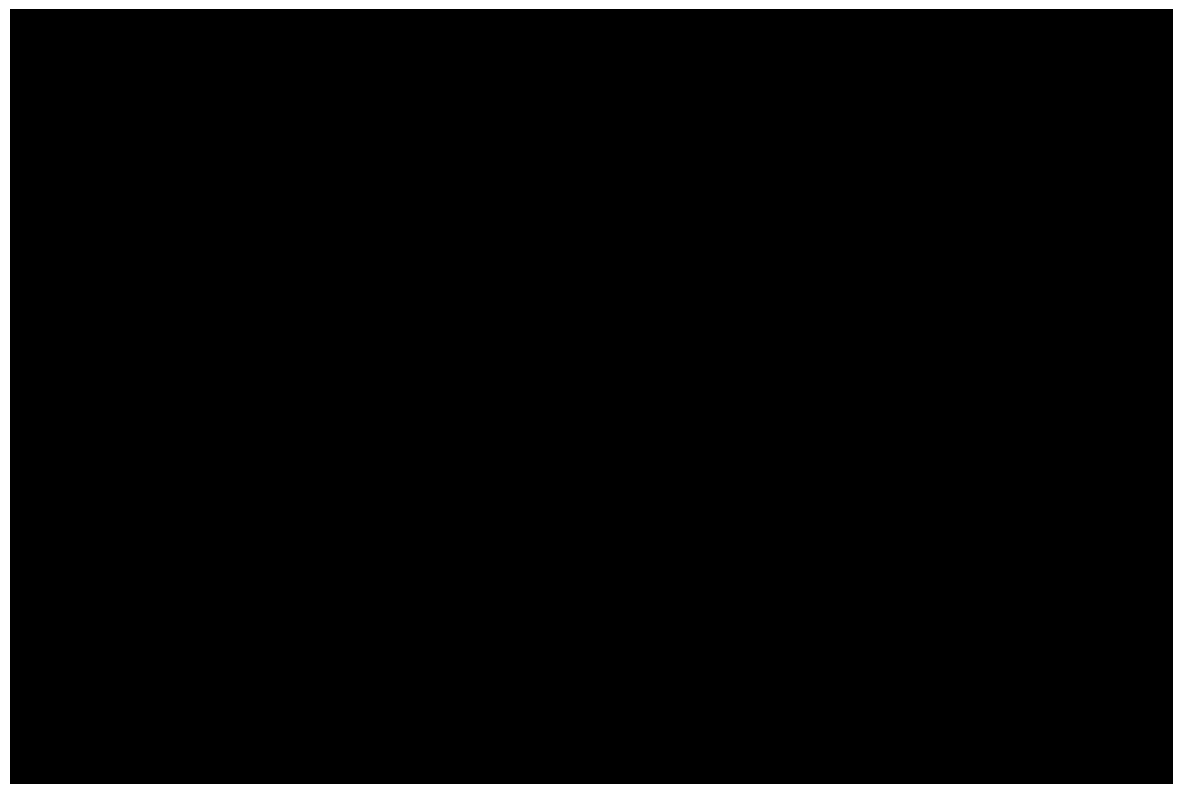

In [ ]:
# Display the rendered image.
plt.imshow(rgb_image.squeeze().cpu().detach().numpy())
plt.axis("off")
